# Lesson 1 - What's your pet

Welcome to lesson 1! For those of you who are using a Jupyter Notebook for the first time, you can learn about this useful tool in a tutorial we prepared specially for you; click `File`->`Open` now and click `00_notebook_tutorial.ipynb`. 

In this lesson we will build our first image classifier from scratch, and see if we can achieve world-class results. Let's dive in!

Every notebook starts with the following three lines; they ensure that any edits to libraries you make are reloaded here automatically, and also that any charts or images displayed are shown in this notebook.

In [2]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

We import all the necessary packages. We are going to work with the [fastai V1 library](http://www.fast.ai/2018/10/02/fastai-ai/) which sits on top of [Pytorch 1.0](https://hackernoon.com/pytorch-1-0-468332ba5163). The fastai library provides many useful functions that enable us to quickly and easily build neural networks and train our models.

In [3]:
from fastai.vision import *
from fastai.metrics import error_rate

If you're using a computer with an unusually small GPU, you may get an out of memory error when running this notebook. If this happens, click Kernel->Restart, uncomment the 2nd line below to use a smaller *batch size* (you'll learn all about what this means during the course), and try again.

In [4]:
bs = 64
# bs = 16   # uncomment this line if you run out of memory even after clicking Kernel->Restart

## Looking at the data

We are going to use the [Oxford-IIIT Pet Dataset](http://www.robots.ox.ac.uk/~vgg/data/pets/) by [O. M. Parkhi et al., 2012](http://www.robots.ox.ac.uk/~vgg/publications/2012/parkhi12a/parkhi12a.pdf) which features 12 cat breeds and 25 dogs breeds. Our model will need to learn to differentiate between these 37 distinct categories. According to their paper, the best accuracy they could get in 2012 was 59.21%, using a complex model that was specific to pet detection, with separate "Image", "Head", and "Body" models for the pet photos. Let's see how accurate we can be using deep learning!

We are going to use the `untar_data` function to which we must pass a URL as an argument and which will download and extract the data.

In [5]:
help(untar_data)

Help on function untar_data in module fastai.datasets:

untar_data(url: str, fname: Union[pathlib.Path, str] = None, dest: Union[pathlib.Path, str] = None, data=True, force_download=False) -> pathlib.Path
    Download `url` to `fname` if `dest` doesn't exist, and un-tgz to folder `dest`.



In [8]:
path = untar_data(URLs.PETS); path

WindowsPath('C:/Users/Roshan/.fastai/data/oxford-iiit-pet')

In [9]:
path.ls()

[WindowsPath('C:/Users/Roshan/.fastai/data/oxford-iiit-pet/annotations'),
 WindowsPath('C:/Users/Roshan/.fastai/data/oxford-iiit-pet/images')]

In [10]:
# If you are an experienced Python programmer, 
# you may not be familiar with this approach of using a slash like this. 
# This is a really convenient function that's part of Python 3. 
# It's functionality from pathlib. Path object is much better to use than strings. 
# They let you use basically create sub paths like this. 
# It doesn't matter if you're on Windows, Linux, or Mac. 
# It is always going to work exactly the same way. 
# path_img is the path to the images in that dataset.

path_anno = path/'annotations'
path_img = path/'images'

The first thing we do when we approach a problem is to take a look at the data. We _always_ need to understand very well what the problem is and what the data looks like before we can figure out how to solve it. Taking a look at the data means understanding how the data directories are structured, what the labels are and what some sample images look like.

The main difference between the handling of image classification datasets is the way labels are stored. In this particular dataset, labels are stored in the filenames themselves. We will need to extract them to be able to classify the images into the correct categories. Fortunately, the fastai library has a handy function made exactly for this, `ImageDataBunch.from_name_re` gets the labels from the filenames using a [regular expression](https://docs.python.org/3.6/library/re.html).

In [11]:
fnames = get_image_files(path_img) 
#will just grab an array of 
# all of the image files based on extension in a path.
fnames[:5]

[WindowsPath('C:/Users/Roshan/.fastai/data/oxford-iiit-pet/images/Abyssinian_1.jpg'),
 WindowsPath('C:/Users/Roshan/.fastai/data/oxford-iiit-pet/images/Abyssinian_10.jpg'),
 WindowsPath('C:/Users/Roshan/.fastai/data/oxford-iiit-pet/images/Abyssinian_100.jpg'),
 WindowsPath('C:/Users/Roshan/.fastai/data/oxford-iiit-pet/images/Abyssinian_101.jpg'),
 WindowsPath('C:/Users/Roshan/.fastai/data/oxford-iiit-pet/images/Abyssinian_102.jpg')]

#### Np.random.seed(seed_value): 
> it is *not* used to generate random numbers but instead used to generate the **same random numbers** <br><br>
> the seed value is used to keep a "deterministic" aspect to the random numbers generated. So if the seed_value=0, then it ( kind of ) stores the pseduo-random numbers generated and makes sure that for the same seed everytime the set of random numbers generated will always be the same. Hence it's followed by the actual generator.<br><br>
> Note: This function doesn't generate random numbers, it only acts as a adjunct to the random number generator.
        

In [12]:
np.random.seed(2)
pat = r'/([^/]+)_\d+.jpg$'

##### ImageDataBunch

> An ImageDataBunch represents all of the data you need to build a model and there's some factory methods which try to make it really easy for you to create that DataBunch - a training set, a validation set with images and labels.
<br><br>
>  we need to extract the labels from the names. We are going to use from_name_re. re is the module in Python that does regular expressions - things that's really useful for extracting text.

In [10]:
data = ImageDataBunch.from_name_re(path_img, fnames, pat, ds_tfms=get_transforms(), size=224, bs=bs
                                  ).normalize(imagenet_stats)

# path_img: a path containing images
# fnames: a list of file names
# pat: a regular expression (i.e. pattern) to be used to extract the label from the file name
# ds_tfms: we'll talk about transforms later
# size: what size images do you want to work with.


##### Limitation of current GPU
    
    > That might seem weird because images have size. This is a shortcoming of current deep learning technology which is that a GPU has to apply the exact same instruction to a whole bunch of things at the same time in order to be fast. If the images are different shapes and sizes, you can't do that. So we actually have to make all of the images the same shape and size

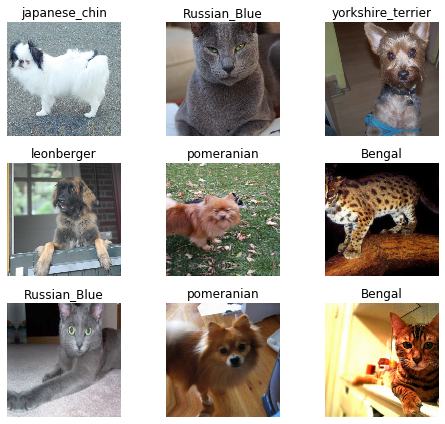

In [11]:
data.show_batch(rows=3, figsize=(7,6))

> data-classes = all of the possible label names<br><br>
> data.c = DataBunch will always have a property called c. We will get to the technical detail later, but for now, you can kind of think of it as being the number of classes. <br><br>
> For things like regression problems and multi-label classification, that's not exactly accurate, but it'll do for now. <br><br>
> It is important to know that data.c is a really important piece of information that is something like, or at least for classification problems it is, the number of classes.<br><br>

In [12]:
print(data.classes)
len(data.classes),data.c

['Abyssinian', 'Bengal', 'Birman', 'Bombay', 'British_Shorthair', 'Egyptian_Mau', 'Maine_Coon', 'Persian', 'Ragdoll', 'Russian_Blue', 'Siamese', 'Sphynx', 'american_bulldog', 'american_pit_bull_terrier', 'basset_hound', 'beagle', 'boxer', 'chihuahua', 'english_cocker_spaniel', 'english_setter', 'german_shorthaired', 'great_pyrenees', 'havanese', 'japanese_chin', 'keeshond', 'leonberger', 'miniature_pinscher', 'newfoundland', 'pomeranian', 'pug', 'saint_bernard', 'samoyed', 'scottish_terrier', 'shiba_inu', 'staffordshire_bull_terrier', 'wheaten_terrier', 'yorkshire_terrier']


(37, 37)

## Training: resnet34

Now we will start training our model. We will use a [convolutional neural network](http://cs231n.github.io/convolutional-networks/) backbone and a fully connected head with a single hidden layer as a classifier. Don't know what these things mean? Not to worry, we will dive deeper in the coming lessons. For the moment you need to know that we are building a model which will take images as input and will output the predicted probability for each of the categories (in this case, it will have 37 outputs).

We will train for 4 epochs (4 cycles through all our data).

In [13]:
learn = cnn_learner(data, models.resnet34, metrics=error_rate)

##### CNN_Learner (creating CNN)
- For now, just know that to create a learner for a convolutional neural network, you just have to tell it two things:
    - data: What's your data. Not surprisingly, it takes a DataBunch.
    - arch: What's your architecture. 
- There are lots of different ways of constructing a convolutional neural network.
- For now, the most important thing for you to know is that there's a particular kind of model called ResNet which works extremely well nearly all the time. 
- For a while, at least, you really only need to be doing choosing between two things which is what size ResNet do you want. 
- There are ResNet34 and ResNet50. 
- Start with a smaller one and see if it's good enough.
- **List of metrics[optional]** - Metrics are literally just things that gets printed out as it's training. So I'm saying I would like you to print out error rate.

##### RESNET34 MODEL:
  - First time we run the model it downloads RESNET34 pre-trained weights
  - It means that the particular model has already been trained for a particular task , which is 1.5 million pictures of different things, 1000 categories of things using an image dataset called ImageNet. 
  - To make sure that the model doesnt start without knowing anything.

In [14]:
learn.model

Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  

### Transfer Learning
- Objective of this course
- Taking a model that already knows how to do something pretty well and make it so that it can do your thing really well. 
- Pretrained model taken and then fit it so that instead of predicting a thousand categories of ImageNet with ImageNet data, it predicts the 37 categories of pets using pet Data within 1/100 or less of the time of regular model training with 1/100 or less of the data of regular model training. 

### Overfitting
- We say the model overfits when it can recognize only those images and none other. 
- That is, for the train data, it gives accurate results, but not for the test data. 
- Hence we create Validation set, which, in this case, is a set of image that the model doesn't get to see. When the DataBunch is created, it automatically creats a validation set. 
- Without validation set it's not possible to know whether we are overfitting, hence the "error_metric" is needed and printed out.
- These are all built in the Databunch Object, no need to be done

### Fitting the Model

- We should nearly always use a method called fit_one_cycle rather than fit. 
- This makes the model more accurate and faster. Source: https://arxiv.org/abs/1803.09820
- Here 4 denotes the number of times we go through the entire dataset, i.e. how many times to show the dataset to the model so that it can learn. This could potentially cause overfitting if done many times. \
- Average error_rate = 9% approx time is 01:22

**TLDR:**
- We found the parameters and coeficients that fit the images and their features

In [15]:
learn.fit_one_cycle(4)

epoch,train_loss,valid_loss,error_rate,time
0,1.397709,0.344754,0.111637,01:22
1,0.626652,0.296912,0.087957,01:19
2,0.373028,0.252232,0.079161,01:20
3,0.257972,0.245547,0.079838,01:27


In [16]:
learn.save('stage-1')

-------
## END OF "WHAT GOES IN THE MODEL"

--------

## Results

Let's see what results we have got. 

We will first see which were the categories that the model most confused with one another. We will try to see if what the model predicted was reasonable or not. In this case the mistakes look reasonable (none of the mistakes seems obviously naive). This is an indicator that our classifier is working correctly. 

Furthermore, when we plot the confusion matrix, we can see that the distribution is heavily skewed: the model makes the same mistakes over and over again but it rarely confuses other categories. This suggests that it just finds it difficult to distinguish some specific categories between each other; this is normal behaviour.

### Loss Function
- function that tells the loss = plot_top_losses
- specifically means that if you predicted one class of cat with great confidence, but actually were wrong, then that's going to have a high loss becuase you were very confident about the **wrong answer**. 
- Plotting this tells us what were the things we were most confident about what we got wrong

In [17]:
interp = ClassificationInterpretation.from_learner(learn)

losses,idxs = interp.top_losses()

len(data.valid_ds)==len(losses)==len(idxs)

True

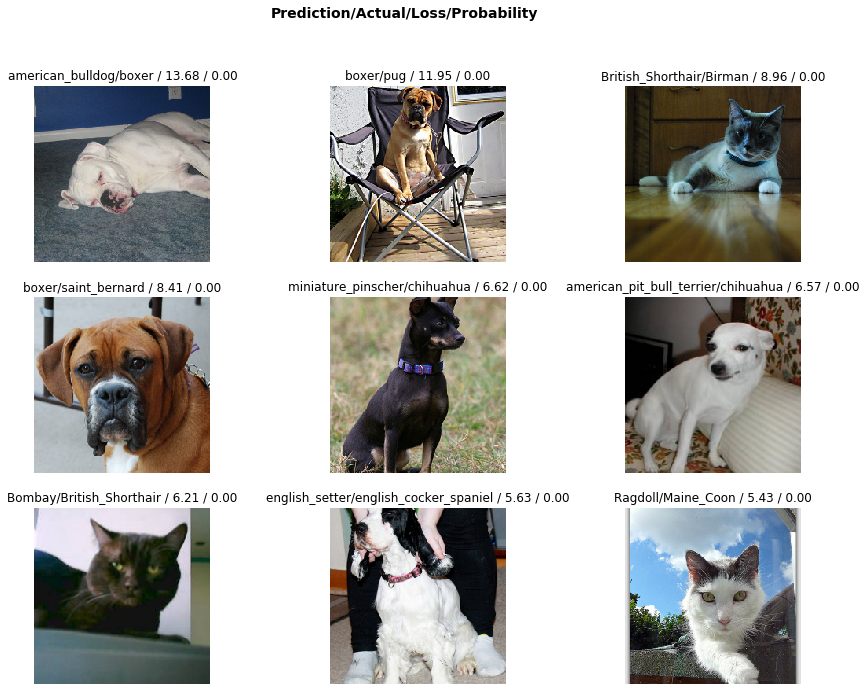

In [18]:
interp.plot_top_losses(9, figsize=(15,11))

In [19]:
doc(interp.plot_top_losses)

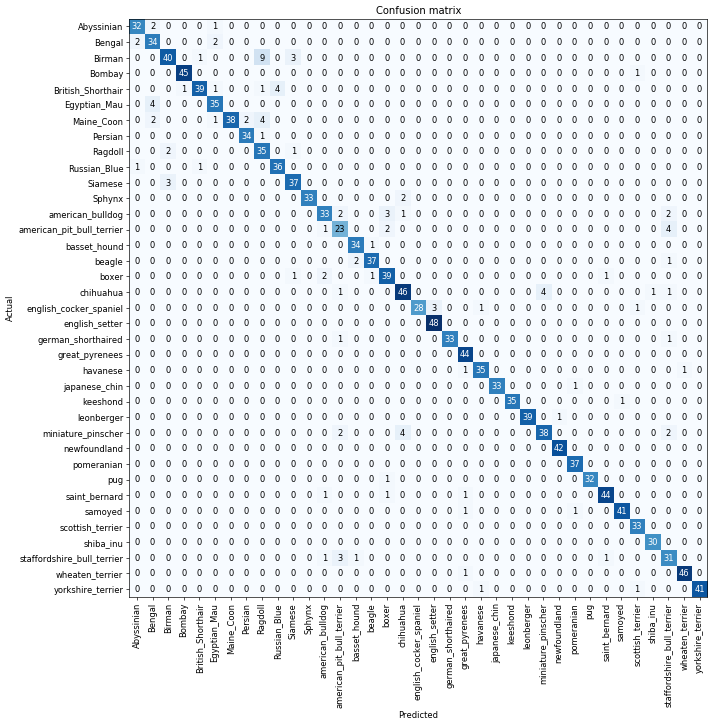

In [20]:
interp.plot_confusion_matrix(figsize=(12,12), dpi=60)

In [21]:
interp.most_confused(min_val=2)

[('Birman', 'Ragdoll', 9),
 ('British_Shorthair', 'Russian_Blue', 4),
 ('Egyptian_Mau', 'Bengal', 4),
 ('Maine_Coon', 'Ragdoll', 4),
 ('american_pit_bull_terrier', 'staffordshire_bull_terrier', 4),
 ('chihuahua', 'miniature_pinscher', 4),
 ('miniature_pinscher', 'chihuahua', 4),
 ('Birman', 'Siamese', 3),
 ('Siamese', 'Birman', 3),
 ('american_bulldog', 'boxer', 3),
 ('english_cocker_spaniel', 'english_setter', 3),
 ('staffordshire_bull_terrier', 'american_pit_bull_terrier', 3),
 ('Abyssinian', 'Bengal', 2),
 ('Bengal', 'Abyssinian', 2),
 ('Bengal', 'Egyptian_Mau', 2),
 ('Maine_Coon', 'Bengal', 2),
 ('Maine_Coon', 'Persian', 2),
 ('Ragdoll', 'Birman', 2),
 ('Sphynx', 'chihuahua', 2),
 ('american_bulldog', 'american_pit_bull_terrier', 2),
 ('american_bulldog', 'staffordshire_bull_terrier', 2),
 ('american_pit_bull_terrier', 'boxer', 2),
 ('beagle', 'basset_hound', 2),
 ('boxer', 'american_bulldog', 2),
 ('miniature_pinscher', 'american_pit_bull_terrier', 2),
 ('miniature_pinscher', 'sta

## Unfreezing, fine-tuning, and learning rates

Since our model is working as we expect it to, we will *unfreeze* our model and train some more.

#### Fine-tuning (Why the neural network ran quickly?)
- We added a few extra layers to the end and we only trained those. 
- i.e. We left most of the model exactly as it was which made it really fast.
- If we try to build a model at something that's similar to the original pre-trained model then it works pretty well. 

### UNFREEZE
- What we really want to do is train the entire model (for better accuracy) 
- By default, when we call fit or fit_one_cycle on a ConvLearner, it'll just fine-tune these few extra layers added to the end and it will run very fast. It will basically never overfit but to really get it good, you have to call unfreeze
- **Unfreeze is the thing that says, please train the whole model. Then we call fit_once_cycle again.**

In [22]:
learn.unfreeze()

In [23]:
learn.fit_one_cycle(1)

epoch,train_loss,valid_loss,error_rate,time
0,0.690865,0.397837,0.113667,01:24


In [24]:
learn.load('stage-1');

#### Learning Rate
- What is the the fastest i can train this neural network at without making it zip off the rails and get blown apart

- lr_find() stops in between when the loss function is very high

In [25]:
learn.lr_find()

epoch,train_loss,valid_loss,error_rate,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


- **Learning Rate basically says how quickly am i updating the parameters in my model**

- As seen here the loss function was very high, and hence it stopped

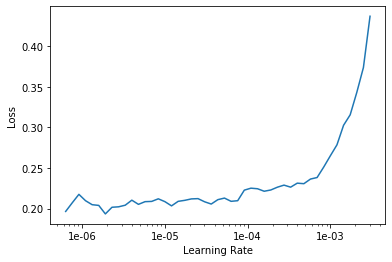

In [27]:
learn.recorder.plot()

- the keyword slice takes the start and a stop value and basically what it says is train the very first layers at a learning rate of 1e-6 and the last at rate of 1e-5 and distribute all the other layers across that
- **NOTE:** We don't pass a value (for ex 1e-6) and instead pass a range because we know that before this, the later layers were working just fine (which used the IMAGENET dataset), we need only tune our layers, hence we pass a range. 

In [29]:
learn.unfreeze()
learn.fit_one_cycle(2, max_lr=slice(1e-06,1e-05))

epoch,train_loss,valid_loss,error_rate,time
0,0.222414,0.235776,0.072395,01:31
1,0.205248,0.230251,0.072395,01:36


That's a pretty accurate model!

### How to pick learning rates after unfreezing
- A good rule of thumb is after you unfreeze (i.e. train the whole thing), pass a max learning rate parameter, pass it a slice, make the second part of that slice about 10 times smaller than your first stage. Our first stage defaulted to about 1e-3 so it's about 1e-4.
- **NOTE** the first part of the slice should be a value from your learning rate finder which is well before things started getting worse. (in the graph, gets worse at around 1e-4 so we choose a bit before like 1e-045 and so on

## Training: resnet50

Now we will train in the same way as before but with one caveat: instead of using resnet34 as our backbone we will use resnet50 (resnet34 is a 34 layer residual network while resnet50 has 50 layers. It will be explained later in the course and you can learn the details in the [resnet paper](https://arxiv.org/pdf/1512.03385.pdf)).

Basically, resnet50 usually performs better because it is a deeper network with more parameters. Let's see if we can achieve a higher performance here. To help it along, let's us use larger images too, since that way the network can see more detail. We reduce the batch size a bit since otherwise this larger network will require more GPU memory.

- Its likely that we get an out of memory error and that's because it's just trying to do too much- too many parameter updates for the amount of RAM we have. 
- To fix this we use the parameter: `bs` at the end, which means batch size. This basically says how many images we need to train at one time. 
- Make bs smaller if we run outta memory. 
- smaller - takes more time.

In [13]:
data = ImageDataBunch.from_name_re(path_img, fnames, pat, ds_tfms=get_transforms(),
                                   size=299, bs=8).normalize(imagenet_stats)

In [14]:
learn = cnn_learner(data, models.resnet50, metrics=error_rate)

epoch,train_loss,valid_loss,error_rate,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


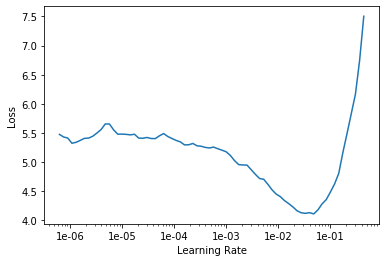

In [15]:
learn.lr_find()
learn.recorder.plot()

In [17]:
learn.fit_one_cycle(8,max_lr=slice(1e-03))

epoch,train_loss,valid_loss,error_rate,time
0,0.975881,0.326286,0.092016,03:02
1,0.724740,0.330939,0.099459,03:06
2,0.683142,0.248117,0.077131,03:05
3,0.482754,0.206562,0.060217,03:12
4,0.433001,0.200071,0.061570,03:10
5,0.293435,0.187312,0.051421,03:07
6,0.320937,0.181337,0.052097,02:50
7,0.356048,0.179360,0.054804,02:39


In [18]:
learn.save('stage-1-50')

It's astonishing that it's possible to recognize pet breeds so accurately! Let's see if full fine-tuning helps:

In [19]:
learn.unfreeze()
learn.fit_one_cycle(3, max_lr=slice(1e-6,1e-4))

epoch,train_loss,valid_loss,error_rate,time
0,0.258687,0.188723,0.056157,03:47
1,0.282729,0.185121,0.054804,03:50
2,0.194762,0.184287,0.053451,03:50


If it doesn't, you can always go back to your previous model.

In [20]:
learn.load('stage-1-50');

In [21]:
interp = ClassificationInterpretation.from_learner(learn)

In [22]:
interp.most_confused(min_val=2)

[('Ragdoll', 'Birman', 5),
 ('american_pit_bull_terrier', 'staffordshire_bull_terrier', 5),
 ('beagle', 'basset_hound', 5),
 ('British_Shorthair', 'Russian_Blue', 4),
 ('Birman', 'Ragdoll', 3),
 ('american_bulldog', 'staffordshire_bull_terrier', 3),
 ('chihuahua', 'miniature_pinscher', 3),
 ('miniature_pinscher', 'chihuahua', 3),
 ('Abyssinian', 'Egyptian_Mau', 2),
 ('Bengal', 'Egyptian_Mau', 2),
 ('British_Shorthair', 'Egyptian_Mau', 2),
 ('Ragdoll', 'Persian', 2),
 ('Russian_Blue', 'Abyssinian', 2),
 ('Siamese', 'Birman', 2),
 ('Sphynx', 'chihuahua', 2),
 ('american_pit_bull_terrier', 'american_bulldog', 2),
 ('boxer', 'american_bulldog', 2),
 ('staffordshire_bull_terrier', 'american_bulldog', 2)]

## Other data formats

#### The following illustrate the different ways in which the data can be labeled and/or extracted.

In [6]:
path = untar_data(URLs.MNIST_SAMPLE); path

WindowsPath('C:/Users/Roshan/.fastai/data/mnist_sample')

In [7]:
path.ls()

[WindowsPath('C:/Users/Roshan/.fastai/data/mnist_sample/labels.csv'),
 WindowsPath('C:/Users/Roshan/.fastai/data/mnist_sample/train'),
 WindowsPath('C:/Users/Roshan/.fastai/data/mnist_sample/valid')]

In [9]:
(path/'train').ls()

[WindowsPath('C:/Users/Roshan/.fastai/data/mnist_sample/train/3'),
 WindowsPath('C:/Users/Roshan/.fastai/data/mnist_sample/train/7')]

## Possibility 1: From folder

- **NOTE:** Notice that there are 2 folders, this is a common way of labeling the datasets. The dataset would be in different folders, each of these folders will be labeled, and accordingly, need to be trained based on the folder label.
- Hence we use `from_folder`

In [10]:
tfms = get_transforms(do_flip=False)
data = ImageDataBunch.from_folder(path, ds_tfms=tfms, size=26)

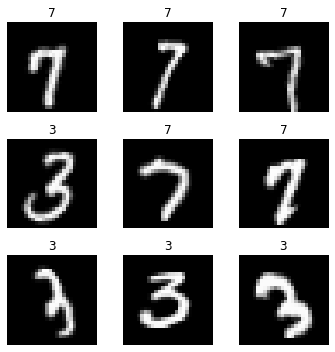

In [18]:
data.show_batch(rows=3, figsize=(5,5))

In [21]:
learn = cnn_learner(data, models.resnet34, metrics=error_rate)
learn.fit(2)

epoch,train_loss,valid_loss,error_rate,time
0,0.163165,0.060456,0.020608,01:08
1,0.093000,0.031784,0.010795,01:09


- Another possibility, and for this MNIST sample, I've got both, it might come with a CSV file that would look something like this.

## Possibility 2: From csv labelled file

In [22]:
df = pd.read_csv(path/'labels.csv')
df.head()

,name,label
0,train/3/7463.png,0
1,train/3/21102.png,0
2,train/3/31559.png,0
3,train/3/46882.png,0
4,train/3/26209.png,0


- For each file name, what's its label. In this case, labels are not three or seven, they are 0 or 1 which basically is it a 7 or not. So that's another possibility. If this is how your labels are, you can use `from_csv`:

#### Option A: Either create directly from csv file

In [23]:
data = ImageDataBunch.from_csv(path, ds_tfms=tfms, size=28)

- And if it is called `labels.csv`, you don't even have to pass in a file name. If it's called something else, then you can pass in the `csv_labels`

[0, 1]

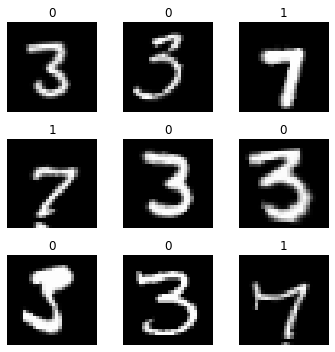

In [24]:
data.show_batch(rows=3, figsize=(5,5))
data.classes

In [25]:
learn = cnn_learner(data,models.resnet34,metrics = error_rate)

In [26]:
learn.fit(2)

epoch,train_loss,valid_loss,error_rate,time
0,0.163484,0.078633,0.023909,01:04
1,0.093814,0.039687,0.015246,01:03


#### Option B: Or create a df and then use the dataframe for the labelled input to the dataBunch

In [52]:
data = ImageDataBunch.from_df(path, df, ds_tfms=tfms, size=24)
data.classes

[0, 1]

- Making into path name to show utilization of regex further

### Option C: Create a list called `fn_paths` which consists a path of each of the images, and then use regex for each path

In [48]:
fn_paths = [path/name for name in df['name']]; fn_paths[:3]

[WindowsPath('C:/Users/Roshan/.fastai/data/mnist_sample/train/3/7463.png'),
 WindowsPath('C:/Users/Roshan/.fastai/data/mnist_sample/train/3/21102.png'),
 WindowsPath('C:/Users/Roshan/.fastai/data/mnist_sample/train/3/31559.png')]

- Using the pathname from before, we now create the regex pattern for the respective images, and accordingly, feeding to get the ImageDataBunch

In [50]:
pat = r"/(\d)/\d+\.png$"
data = ImageDataBunch.from_name_re(path, fn_paths, pat=pat, ds_tfms=tfms, size=24)
data.classes

['3', '7']

### Option D: Use Lambda function instead of Regex 

##### Lambda Function
- A lambda function is a small anonymous function.
- A lambda function can take any number of arguments, but can only have one expression.
- Ex: r = lambda x: x+10;<br>
    print(r(5))

In [51]:
data = ImageDataBunch.from_name_func(path, fn_paths, ds_tfms=tfms, size=24,
        label_func = lambda x: '3' if '/3/' in str(x) else '7')
data.classes

['7']

#### Not working quite as expected-- SOME ISSUE : TO BE RESOLVED

### Possibility 3: Create a list for the labels, then use `from _lists` for the DataBunch

In [53]:
# List comprehension
labels = [('3' if '/3/' in str(x) else '7') for x in fn_paths]
labels[:5]

['7', '7', '7', '7', '7']

In [37]:
data = ImageDataBunch.from_lists(path, fn_paths, labels=labels, ds_tfms=tfms, size=24)
data.classes

['7']